<a href="https://colab.research.google.com/github/lamontdobbins3-stack/myProjects/blob/main/LoanApprovalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display

# Data Cleaning

In [ ]:
# Load the dataset
df = pd.read_csv("loan_sanction_train.csv")

# Display the first few rows
df.head()

# Replace '3+' with '3'
df['Dependents'] = df['Dependents'].replace('3+', '3')

# Get Dummies
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Drop rows with missing values
df_cleaned = df.dropna().copy()

# Convert all boolean columns to integer
bool_cols = df_cleaned.select_dtypes(include=['bool']).columns
df_cleaned[bool_cols] = df_cleaned[bool_cols].astype(int)

# Avoid Loan ID and convert to Int
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].astype(int)

# Export cleaned data
df_cleaned.to_csv("cleaned_loan_data.csv", index=False)

# Display the first few rows of the cleaned dataset
df_cleaned.head()

# Convert object columns storing numerical values to a numerical data type for data analysis.
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        try:
            df_cleaned[col] = df_cleaned[col].astype('int32')
        except ValueError:
            print(f"Could not convert column '{col}' to numeric.")

#Legend
#Male = 1 Female = 0
#Married Yes = 1 No =0
#Graduate No = 1 Yes = 0
#Self Employed Yes = 1 No = 0
#Semiurban Yes = 1 No = 0
#Urban Yes = 1 No = 0

Could not convert column 'Loan_ID' to numeric.


# Hypothesis Testing

## T-test

In [ ]:
# Hypothesis testing 1 (t-test)
# We are using a t-test to compare the average applicant income between loan approval status
# Null Hypothesis: There is no difference in average income between approved and rejected loan applicants
# Alternative Hypothesis: There is a difference in average income between approved and rejected loan applicats; approved applications have a significantly different average income

# Filter the dataset for the two cases that we want to compare:
approved = df_cleaned[df_cleaned['Loan_Status_Y'] == 1]['ApplicantIncome']
rejected = df_cleaned[df_cleaned['Loan_Status_Y'] == 0]['ApplicantIncome']

# Run t-test
t_stat, p_value = stats.ttest_ind(approved, rejected, equal_var=False)

# Set significance level
alpha = 0.05

# Print the results
print(f"t_stat: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Print the conclusion
if p_value < alpha:
    print('Reject the null hypothesis; income is significantly associated with loan approval.')
else:
    print('Fail to reject the null hypothesis; the difference in income btween approved and rejected loan applicants is not statistically significant.')

t_stat: -0.17
P-value: 0.8622
Fail to reject the null hypothesis; the difference in income btween approved and rejected loan applicants is not statistically significant.


In [ ]:
# Hypothesis testing 2 (t-test)
# We are using a t-test to compare the average applicant income between loan approval status
# Null Hypothesis: There is no difference in average total income (applicant income + coapplicant income) between approved and rejected applicants
# Alternative Hypothesis: There is a difference in average total income (applicant income + coapplicant income) between approved and rejected applicats; approved applications have a significantly different average total income

df_cleaned['Total Income'] = df_cleaned['ApplicantIncome'] + df_cleaned['CoapplicantIncome']
# If CoapplicantIncome is 0, just use ApplicantIncome
df_cleaned.loc[df_cleaned['CoapplicantIncome'] == 0, 'Total Income'] = df_cleaned['ApplicantIncome']

# Filter the dataset for the two cases that we want to compare:
approved = df_cleaned[df_cleaned['Loan_Status_Y'] == 1]['Total Income']
rejected = df_cleaned[df_cleaned['Loan_Status_Y'] == 0]['Total Income']

# Run t-test
t_stat, p_value = stats.ttest_ind(approved, rejected, equal_var=False)

# Set significance level
alpha = 0.05

# Print the results
print(f"t_stat: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Print the conclusion
if p_value < alpha:
    print('Reject the null hypothesis; total income is significantly associated with loan approval.')
else:
    print('Fail to reject the null hypothesis; the difference in total income btween approved and rejected loan applicants is not statistically significant.')

t_stat: -0.52
P-value: 0.6049
Fail to reject the null hypothesis; the difference in total income btween approved and rejected loan applicants is not statistically significant.


## One-way ANOVA

In [ ]:
# Hypothesis testing 3 (ANOVA)
# We are using ANOVA to compare the loan approval rates across the three different property areas (Urban, Semiurban, and Rural)
# Null Hypothesis: The property area does not affect loan approval rates (loan approval rates are the same across different property areas)
# Alternative Hypothesis: The property area affects loan approval rates (loan approval rates are different across the three property areas)

# Filter the dataset for the loan approval status of the three cases (property area) that we want to compare:
semiurban = df_cleaned[df_cleaned['Property_Area_Semiurban'] == 1]['Loan_Status_Y']
urban = df_cleaned[df_cleaned['Property_Area_Urban'] == 1]['Loan_Status_Y']
rural = df_cleaned[(df_cleaned['Property_Area_Semiurban'] == 0) & (df_cleaned['Property_Area_Urban'] == 0)]['Loan_Status_Y']

# Perform ANOVA to test for significant differences between group means
f, p = stats.f_oneway(semiurban, urban, rural)

# Print the results
print(f"F Statistic: {f:.2f}")
print(f"P-value: {p:.4f}")

# Set significance level
alpha = 0.05

# Print the conclusion
if p < 0.05:
    print('Reject null hypothesis: property area affects loan approval rates, loan approval rates are different across the three property areas.')
else:
    print('Fail to reject null hypothesis: property area does not affect loan approval rates, loan approval rates are the same across the three property areas')

F Statistic: 6.31
P-value: 0.0020
Reject null hypothesis: property area affects loan approval rates, loan approval rates are different across the three property areas.


## Chi-square Test of Independence

In [ ]:
# Hypothesis testing 4 (chi-square test of independence)
# We are using Chi-Square Test of Independence because both columns are categorical
# Null Hypothesis: Credit history is not associated with loan approval
# Alternative Hypothesis: Credit history does affect whether you get loan approval

# Create a contingency table
credit_contingency = pd.crosstab(df_cleaned['Credit_History'], df_cleaned['Loan_Status_Y'])

# Run the chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(credit_contingency)

# Print results
print(f"Chi2 Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_val:.4e}")

# Set significance level
alpha = 0.05

# Print the conclusion
if p_val < alpha:
    print('Reject null hypothesis: credit history is associated with loan approval.')
else:
    print('Fail to reject null hypothesis: no significant difference between credit history and loan approval.')

Chi2 Statistic: 144.57
P-value: 2.6601e-33
Reject null hypothesis: credit history is associated with loan approval.


# EDA and Visualizations

## Univariate Analysis

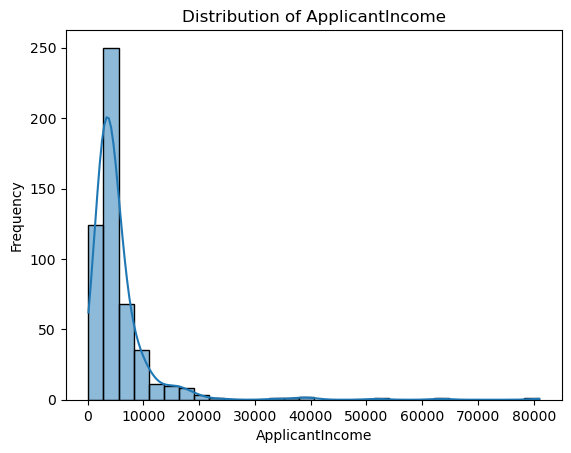

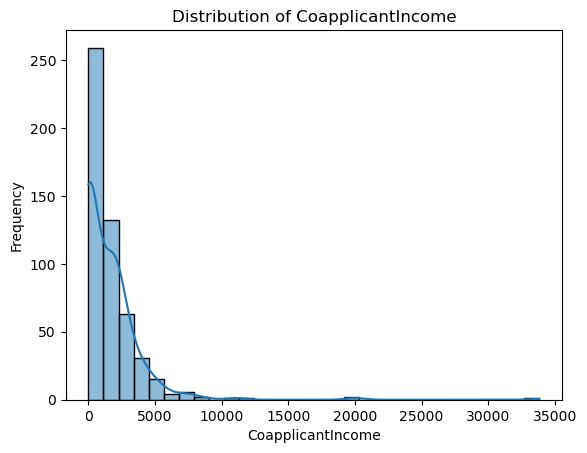

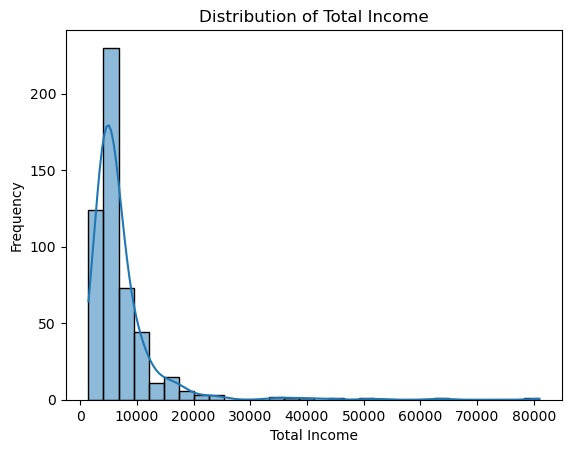

In [ ]:
# EDA and Visualizations 1
# Univariate Analysis

# Histograms for numeric variables
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'Total Income']
for col in numeric_cols:
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Bivariate Analysis

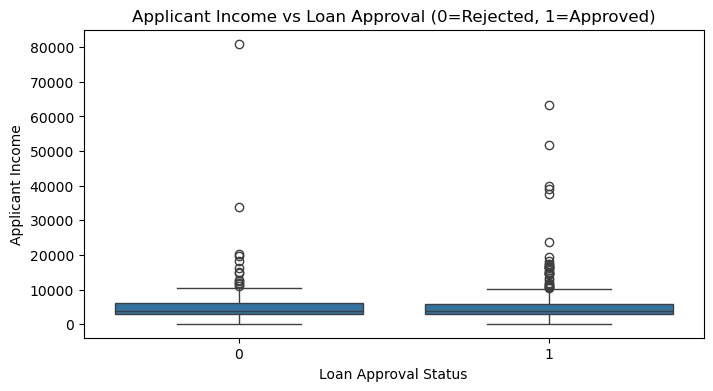

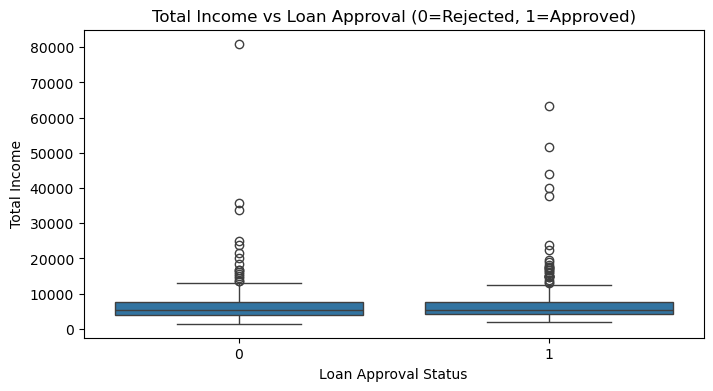

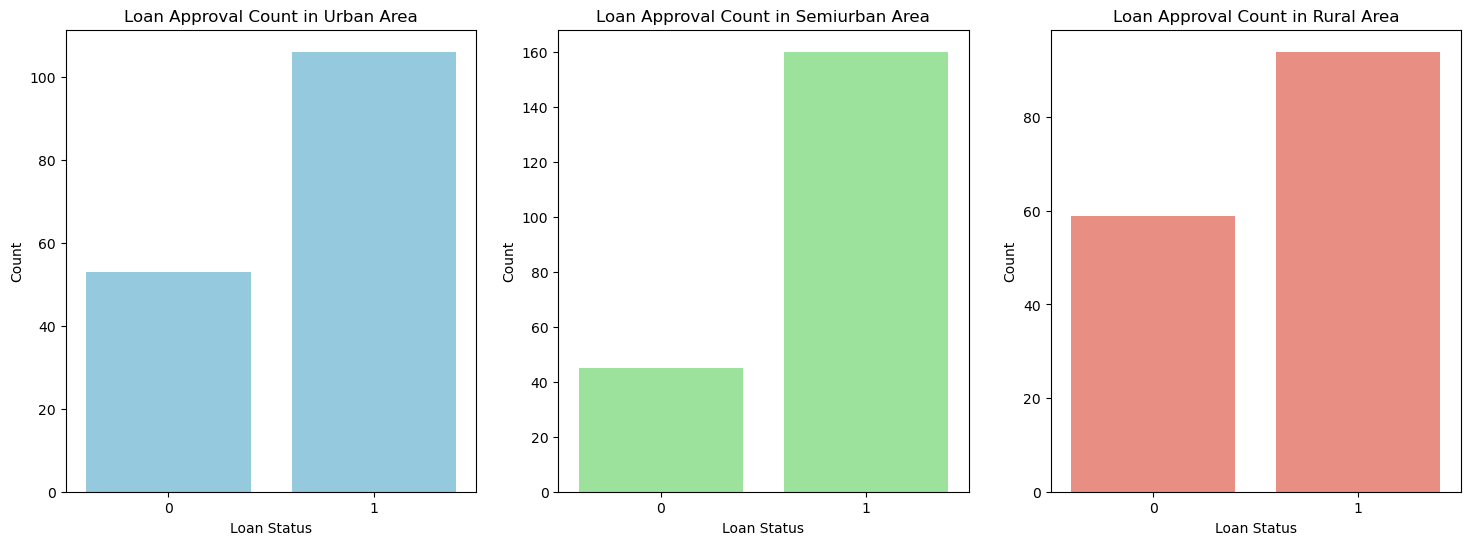

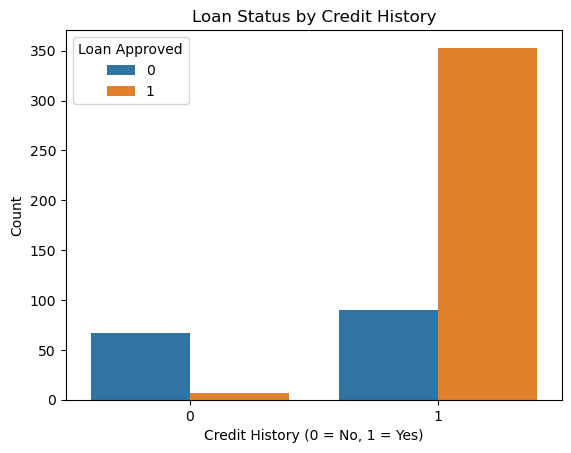

In [ ]:
# EDA and Visulaization 2
# Bivariate Analysis

# Boxplots of ApplicantIncome by Loan Status
plt.figure(figsize=(8,4))
sns.boxplot(x='Loan_Status_Y', y='ApplicantIncome', data=df_cleaned)
plt.title('Applicant Income vs Loan Approval (0=Rejected, 1=Approved)')
plt.xlabel('Loan Approval Status')
plt.ylabel('Applicant Income')
plt.show()

# Boxplots of TotalIncome by Loan Status
plt.figure(figsize=(8,4))
sns.boxplot(x='Loan_Status_Y', y='Total Income', data=df_cleaned)
plt.title('Total Income vs Loan Approval (0=Rejected, 1=Approved)')
plt.xlabel('Loan Approval Status')
plt.ylabel('Total Income')
plt.show()

#Visualizing property areas based on loan approval status (approved vs. rejected)

# Set up the figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define list of property areas
property_areas = ['Urban', 'Semiurban', 'Rural']

# Define list of color for each property area
colors = ['skyblue', 'lightgreen', 'salmon']

# Index variable to iterate through
i = 0

# Loop through the property areas and create plots for each
for area in property_areas:
    # Filter data based on Property Area
    if area == 'Urban':
        data = df_cleaned[df_cleaned['Property_Area_Urban'] == 1]
    elif area == 'Semiurban':
        data = df_cleaned[df_cleaned['Property_Area_Semiurban'] == 1]
    else:
        data = df_cleaned[(df_cleaned['Property_Area_Semiurban'] == 0) &
                          (df_cleaned['Property_Area_Urban'] == 0)]

    # Plot the countplot
    sns.countplot(x='Loan_Status_Y', data=data, ax=axes[i], color=colors[i])

    # Set title and labels for each subplot
    axes[i].set_title(f'Loan Approval Count in {area} Area')
    axes[i].set_xlabel('Loan Status')
    axes[i].set_ylabel('Count')

    # Incrementing index, move on to next property_area
    i+=1

# Show the plot
plt.show()

# Countplot for credit history and loan approval
sns.countplot(data=df_cleaned, x='Credit_History', hue='Loan_Status_Y')
plt.title('Loan Status by Credit History')
plt.xlabel('Credit History (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.legend(title='Loan Approved')
plt.show()

## Correlation Analysis

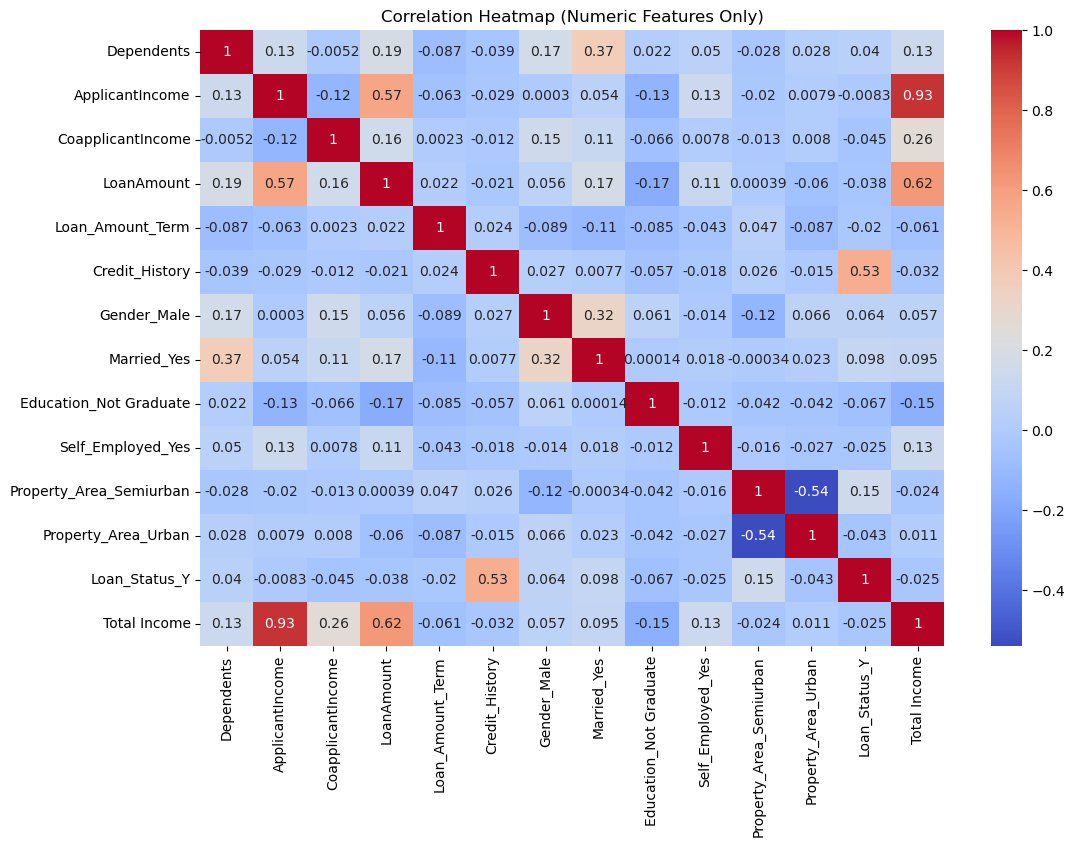

In [ ]:
# EDA and Visualization 3
# Correlation Analysis

numeric_df = df_cleaned.select_dtypes(include=['int64', 'float64', 'int32', 'uint8'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()

# Predictive Analysis

## Logistic Regression

In [ ]:
# Separating the dependent variable (Loan_Status_Y) from the predictor variables.
X = df_cleaned[['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',	'Loan_Amount_Term',	'Credit_History', 'Gender_Male',
                'Married_Yes','Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']]
y = df_cleaned[['Loan_Status_Y']]

#Verifying the first 10 rows of each list
print('Dataframe for predictor  variables: ')
display(X.head())
print('Length: ' + str(len(X)))
print( )
print( )
print('Dataframe for dependent variables: ')
display(y.head())
print('Length: ' + str(len(y)))

Dataframe for predictor  variables: 


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
1,1,4583,1508,128,360,1,1,1,0,0,0,0
2,0,3000,0,66,360,1,1,1,0,1,0,1
3,0,2583,2358,120,360,1,1,1,1,0,0,1
4,0,6000,0,141,360,1,1,0,0,0,0,1
5,2,5417,4196,267,360,1,1,1,0,1,0,1


Length: 517


Dataframe for dependent variables: 


,Loan_Status_Y
1,0
2,1
3,1
4,1
5,1


Length: 517


In [ ]:
# Defining the logistic regression model and fit the data.
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.458660
         Iterations 6


In [ ]:
# printing the summary of the logistic regression model
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:          Loan_Status_Y   No. Observations:                  517
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                           11
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                  0.2529
Time:                        22:30:22   Log-Likelihood:                -237.13
converged:                       True   LL-Null:                       -317.41
Covariance Type:            nonrobust   LLR p-value:                 1.024e-28
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Dependents                  0.0987      0.127      0.779      0.436      -0.150       0.347
ApplicantIncome          7.887e-06   2.44e-05      0.324      0.746   -3.99e-05    5.56e-05


## Odds Ratios

In [ ]:
# Calculate the odds ratios for each predictor and output them.
print('Odds Ratios for Each Predictor: ')
odds_ratios = np.exp(result.params)
display(odds_ratios)

Odds Ratios for Each Predictor: 


Dependents                  1.103773
ApplicantIncome             1.000008
CoapplicantIncome           0.999955
LoanAmount                  0.997188
Loan_Amount_Term            0.993670
Credit_History             31.806634
Gender_Male                 1.144262
Married_Yes                 1.480332
Education_Not Graduate      0.596032
Self_Employed_Yes           0.826045
Property_Area_Semiurban     2.353637
Property_Area_Urban         0.989635
dtype: float64